In [64]:
import numpy as np
import csv
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
COLORS = list(colors.CSS4_COLORS.keys())
import plotly.express as px
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import warnings
import scipy
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import random
import FloRodMethods as frm
import time
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Reshape
import tensorflow as tf
import keras
%matplotlib inline

In [2]:
def load_region(file):  
    df = pd.read_csv(file)
    df.index = df['timestamp']
    del df['timestamp']
    return df

In [3]:
DAYS = [31,28,31,30,31,30,31,31,30,31,30,31]
#useful tool for seeing which day of the year marks the beginning of various months
DAYS_SUM = [sum(DAYS[0:k]) for k in range(12)]
DAYS_SUM

[0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]

In [4]:
df = load_region('C:/Users/DJFRO/Hubs/Clustering/county1000.csv')

In [5]:
clusters = np.load('kmeans112.npy')

In [6]:
data = np.asarray(df[DAYS_SUM[5]*24*4:DAYS_SUM[8]*24*4]).astype('float16').T
#only rows corresponding to june through august, and transposing it in the form of an array
blds, t_len = data.shape
num_days = t_len//(24*4)
data_days = data.reshape(blds,num_days,24*4)
#tensor of blds, by days, by daily measurements

## Choosing a cluster

In [7]:
c = 71

In [8]:
blds_in_c = np.squeeze(np.argwhere((clusters==71).astype(int)))
print('cluster: ',c,' \nhas buildings: ',blds_in_c)
blds_tst =  blds_in_c[[1,4,8]]
print('we choose: ',blds_tst)


cluster:  71  
has buildings:  [ 128  148  282  362  699  801  834 1001 1064]
we choose:  [ 148  699 1064]


Building  128  in cluster  71


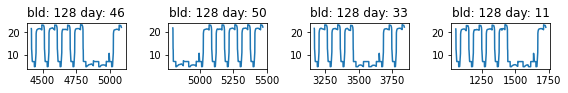



Building  148  in cluster  71


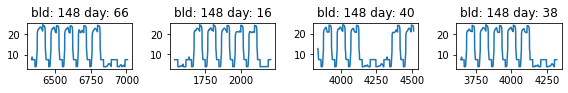



Building  282  in cluster  71


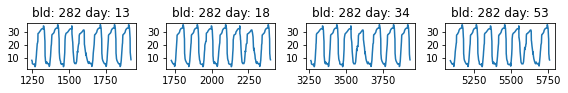



Building  362  in cluster  71


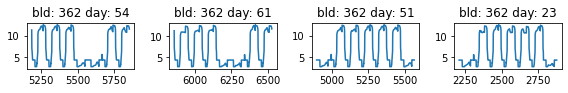



Building  699  in cluster  71


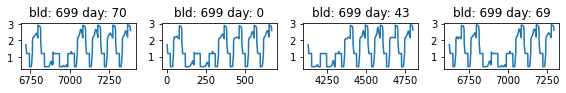



Building  801  in cluster  71


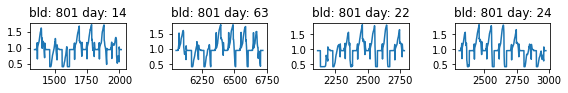



Building  834  in cluster  71


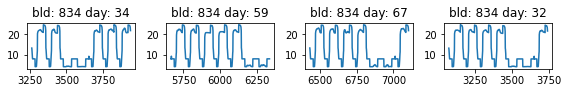



Building  1001  in cluster  71


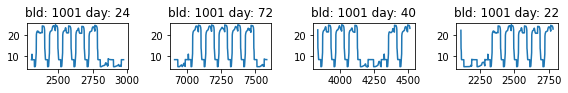



Building  1064  in cluster  71


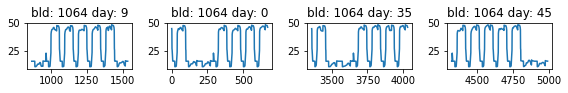

In [9]:
#data analysis
for j in blds_in_c:
    print('Building ',j,' in cluster ',c)
    plt.subplots(1,4, figsize = (8,1.4))
    bld = j
    for i in range(4):
        plt.subplot(1,4,i+1)
        day = np.random.randint(0,num_days-8)
        plt.plot(np.arange(day*24*4,(day+7)*24*4),data[bld,day*24*4:(day+7)*24*4])
        plt.title('bld: '+str(bld)+ ' day: '+str(day))
    plt.tight_layout()
    plt.show()
    print('\n')
    

In [10]:
# xs = {}
# for bld in blds_in_c:
#     x,y = frm.splitSeqs(data[bld],14*24*4,24*4)
#     #generates x y pairs of sequential data with inputs of two weeks and a day output
#     #but it's raw data, which isn't too useful alone (some 7300 datapoints made per
#     #building)
#     xs['x'+str(bld)] = x
#     xs['y'+str(bld)] = y

## Now we'll extract weekdays and normalize the data

In [11]:
dataWeeks = data[128,:91*24*4].reshape(-1,7*24*4)

In [12]:
weekdays = np.concatenate([dataWeeks[:,:24*4],dataWeeks[:,24*4*3:]],axis=1)

In [13]:
x,y = frm.splitSeqs(weekdays.reshape(-1),1,24*4)

In [14]:
yn = (y-np.mean(y,axis=1,keepdims=True))/np.std(y,axis=1,keepdims=True)

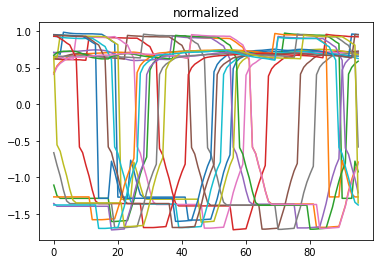

In [15]:
frm.showRandRows(yn,20)
plt.title('normalized');

In [71]:
# train a generative adversarial network on a one-dimensional function


'''     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()]) '''



def define_discriminator(n_inputs=24*4,lr = 1e-3,in_shape=None):
    model = Sequential()
    model.add(Dense(24*2, activation='relu', kernel_initializer='he_uniform', input_shape=in_shape))

    model.add(Conv1D(1,4))
    model.add(Dense(18, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(9, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                  metrics=['accuracy'])
#     model.summary()
    return model
 
# define the standalone generator model
def define_generator(latent_dim, n_outputs=24*4, in_shape=None):
    model = Sequential()
    model.add(Dense(16, activation='tanh', kernel_initializer='he_uniform', input_shape=in_shape))
    model.add(Dense(16, activation='tanh', kernel_initializer='he_uniform'))
    model.add(Dense(24, activation='tanh', kernel_initializer='he_uniform'))
    model.add(Conv1DTranspose(n_outputs,1))
    model.add(Dense(n_outputs, activation='linear'))
    return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator, lr=1e-3):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr))
#     model.summary()
    return model
 
# generate n real samples with class labels
def generate_real_samples(x,n):
    # generate inputs in [-0.5, 0.5]
    np.random.shuffle(x)

    X = x[:n,:,:]
    # generate class labels
    y = np.ones((n, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    #made a method to allow future editing
    return np.random.randn(n,latent_dim,1)
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = np.zeros((n, 1))
    return X, y
 
# evaluate the discriminator and plot real and fake curves
def summarize_performance(epoch, generator, discriminator, latent_dim,
                          n=20, M=None, saveplot=False,label=''):
    # prepare real samples
    x_real, y_real = generate_real_samples(M,n)
    
    # evaluate discriminator on real examples
    loss_real, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    loss_fake, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('EPOCH: ',epoch,'  REAL ACC: ', acc_real,'  FAKE ACC: ', acc_fake)
    print('xreal ',x_real.shape, 'x_fake' ,x_fake.shape)

    frm.dispRandRows(x_real,12, figsize=(8,4), 
                 title='real signals at '+str(epoch)+' epochs')
    plt.show()

    frm.dispRandRows(x_fake,12, figsize=(8,4),
                 title='fake signals at '+str(epoch)+' epochs')
    if saveplot:
        plt.savefig('records/'+label)
    plt.show()
    return

# evaluate the discriminator and plot real and fake curves
def save_progress(epoch, generator, discriminator, latent_dim,
                  x_real, y_real,x_fake, y_fake, progress = [], label=''):
    # evaluate discriminator on real examples
    loss_real, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # evaluate discriminator on fake examples
    loss_fake, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    progress.append([epoch,loss_real, acc_real,loss_fake, acc_fake])
    df = pd.DataFrame(progress,columns=['epoch','r_loss','r_acc','f_loss','f_acc'])
    df.to_csv('records/'+label+'.csv')
    return

# train the generator and discriminator

def train(g_model, d_model, gan_model, latent_dim, n_epochs=1000,
          n_batch=128, n_eval=100, M=None, label='', n_save=50):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    progress=[]
    # manually enumerate epochs
    t0 = time.time()
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(M,half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if i % n_eval == 0 or i+1==n_epochs:
            if i+1!=n_epochs:
                summarize_performance(i, g_model, d_model, latent_dim,M=M)
            else:
                summarize_performance(i, g_model, d_model, latent_dim,M=M,
                                      saveplot=True, label=label)
            dt = time.time()-t0
            print((label+' ')*4+'\n',"We're doing about 200 epochs in ", 
                  np.round(dt*200/((i+1)*60),2), ' min')
        if (i+1) % n_save==0 or i+1==n_epochs:
            save_progress(i, generator, discriminator, latent_dim,
                  x_real, y_real,x_fake, y_fake, progress = progress, label=label) 
    timestr = tstr()[4:-8]
    g_model.save('models/gen_'+label+timestr)  
    d_model.save('models/disc_'+label+timestr) 
    gan_model.save('models/GAN_'+label+timestr) 
    return


In [72]:
yn_tensor = yn.reshape(yn.shape[0],yn.shape[1],1)

In [73]:

# size of the latent space
latent_dim = 16
batch = 128
# create the discriminator
discriminator = define_discriminator(n_inputs=24*4,in_shape=(batch,24*4,1))
# create the generator
generator = define_generator(latent_dim, n_outputs =24*4,in_shape=(batch,latent_dim,1))
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim,M=yn_tensor, n_epochs=10000,n_eval=2000, label ='Conv')

ValueError: in user code:

    C:\Users\DJFRO\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Users\DJFRO\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\DJFRO\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\DJFRO\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\DJFRO\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\DJFRO\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\Users\DJFRO\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\training.py:795 train_step
        y_pred = self(x, training=True)
    C:\Users\DJFRO\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\DJFRO\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\sequential.py:380 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    C:\Users\DJFRO\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\functional.py:420 call
        return self._run_internal_graph(
    C:\Users\DJFRO\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\functional.py:556 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\DJFRO\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\DJFRO\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\functional.py:1447 call
        return getattr(self._module, self._method_name)(*args, **kwargs)
    C:\Users\DJFRO\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py:989 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\DJFRO\AppData\Roaming\Python\Python39\site-packages\keras\engine\input_spec.py:248 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense_108 is incompatible with the layer: expected axis -1 of input shape to have value 1 but received input with shape (64, 16, 96)


In [45]:
yn_tensor.shape

(6144, 96, 1)

In [50]:
64*16

1024